<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_09_auto_ml_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Tuning

In [0]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

In [0]:
#!pip install -U imblearn
#!pip install -U xgboost
# !pip install -U featuretools

# https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
# https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
# https://machinelearningmastery.com/imbalanced-classification-model-to-detect-oil-spills/

In [3]:
if COLAB:
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects

Cloning into 'dl-projects'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 1878 (delta 47), reused 7 (delta 3), pack-reused 1802
Receiving objects: 100% (1878/1878), 77.12 MiB | 34.55 MiB/s, done.
Resolving deltas: 100% (1158/1158), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

In [0]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys
import gc

from scipy import stats
from collections import Counter
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import featuretools as ft
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, make_scorer, recall_score, roc_curve, mean_squared_error, accuracy_score, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     AllKNN,
                                     NearMiss,
                                     OneSidedSelection,
                                     EditedNearestNeighbours)
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN 
import pylab as pl
import xgboost as xgb
from collections import Counter
from dateutil.relativedelta import relativedelta


# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
# from scikitplot.plotters import plot_precision_recall_curve

from utils import feature_selection, plot_feature_importances
from preprocess import *
from plot import plot_correlation_matrix, plot_labeled_scatter

from IPython.display import display

np.set_printoptions(threshold=sys.maxsize)

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [7]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [8]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [9]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("../datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 4720M
-rw------- 1 root root 2454M Jan 12 01:24 feature_matrix_d2_v2.ft
-rw------- 1 root root 1585M Jan 12 23:39 feature_matrix_d2_v3.ft
-rw------- 1 root root   17M Feb 21 13:07 feature_matrix_snapshot.ft
-rw------- 1 root root   17M Feb 21 13:07 feature_matrix_snapshot_origin.pkl
-rw------- 1 root root    5M Jan 30 04:33 orig_X_test.ft
-rw------- 1 root root  415M Jan 30 04:33 orig_X_train.ft
-rw------- 1 root root    1M Jan 30 04:33 orig_y_test.ft
-rw------- 1 root root    7M Jan 30 04:33 orig_y_train.ft
-rw------- 1 root root    3M Feb 29 08:34 test_X_test.ft
-rw------- 1 root root  213M Feb 29 08:34 test_X_train.ft
-rw------- 1 root root    1M Feb 29 08:34 test_y_test.ft
-rw------- 1 root root    7M Feb 29 08:34 test_y_train.ft
total 25M
-rw-r--r-- 1 root root  1M Feb 29 12:49 4D.zip
-rw-r--r-- 1 root root 25M Feb 29 12:49 labels.csv


In [0]:
# Read the data
data = pd.read_feather(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

## Exploratory Data Analysis

### View data

In [0]:
# Feature matrix
feature_matrix = data.drop(columns=['NumberId', 'month', 'year'])

In [12]:
# Sort data
feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959893 entries, 7020 to 956511
Columns: 214 entries, time to LAST(Results.PrizeType)_Prize
dtypes: datetime64[ns](1), float64(155), int64(56), uint8(2)
memory usage: 1.5 GB


In [13]:
print('Distribution')
print(feature_matrix['Label'].value_counts())
print()
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Distribution
0    927839
1     32054
Name: Label, dtype: int64

Positive: 927839 which is  96.66 % of the dataset
Negative: 32054 which is  3.34 % of the dataset


In [14]:
feature_matrix.isna().sum().sort_values(ascending=False)

SKEW(Results.TIME_SINCE_PREVIOUS(DrawDate))               7636
CUM_MEAN(TREND(Results.LuckyNo, DrawDate))                7636
TREND(Results.TIME_SINCE_PREVIOUS(DrawDate), DrawDate)    7636
TREND(Results.CUM_MEAN(TotalStrike), DrawDate)            7636
TREND(Results.CUM_SUM(LuckyNo), DrawDate)                 7636
                                                          ... 
CUM_SUM(MIN(Results.DrawNo))                                 0
NUM_UNIQUE(Results.DAY(DrawDate))                            0
NUM_UNIQUE(Results.MONTH(DrawDate))                          0
SUM(Results.PERCENTILE(LuckyNo))                             0
time                                                         0
Length: 214, dtype: int64

### Feature Selection

In [0]:
# Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [16]:
feature_matrix.shape

(959893, 214)

In [17]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label']))
# feature_matrix_selection = feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label'])

Original shape:  (959893, 211)
0 missing columns with threshold: 90.
41 zero variance columns.
109 collinear columns removed with threshold: 0.95.
Total columns removed:  150
Shape after feature selection: (959893, 61).


In [18]:
feature_matrix_selection.shape, feature_matrix_selection.columns

((959893, 61),
 Index(['STD(Results.DrawNo)', 'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
        'TREND(Results.DrawNo, DrawDate)', 'MONTH(first_Results_time)',
        'DAY(first_Results_time)', 'TIME_SINCE(first_Results_time)',
        'TIME_SINCE_PREVIOUS(first_Results_time)',
        'STD(Results.PERCENTILE(DrawNo))',
        'STD(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'STD(Results.CUM_SUM(DrawNo))', 'STD(Results.CUM_MEAN(LuckyNo))',
        'MAX(Results.PERCENTILE(DrawNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MAX(Results.CUM_MEAN(LuckyNo))',
        'MIN(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'MIN(Results.CUM_MEAN(LuckyNo))', 'MODE(Results.MONTH(DrawDate))',
        'MODE(Results.DAY(DrawDate))', 'MEAN(Results.TIME_SINCE(DrawDate))',
       

In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['TotalStrike'] = feature_matrix['TotalStrike']
feature_matrix_selection['Label'] = feature_matrix['Label']

### Feature Correlation

In [20]:
feature_matrix.isnull().sum().sort_values(ascending=False)

LAST(Results.PrizeType)_Prize                  0
SKEW(Results.TIME_SINCE(DrawDate))             0
MEAN(Results.CUM_MEAN(TotalStrike))            0
MEAN(Results.CUM_MEAN(LuckyNo))                0
MEAN(Results.CUM_SUM(DrawNo))                  0
                                              ..
CUM_SUM(COUNT(Results))                        0
CUM_SUM(MAX(Results.DrawNo))                   0
CUM_SUM(MEAN(Results.LuckyNo))                 0
CUM_SUM(AVG_TIME_BETWEEN(Results.DrawDate))    0
time                                           0
Length: 214, dtype: int64

In [0]:
# Check with feature selection
corrs = feature_matrix_selection.corr().sort_values('Label')

In [22]:
corrs['Label'].head(60)

CUM_MEAN(SUM(Results.LuckyNo))                           -0.003288
TIME_SINCE(first_Results_time)                           -0.002944
STD(Results.DrawNo)                                      -0.002877
STD(Results.CUM_SUM(DrawNo))                             -0.002778
MAX(Results.LuckyNo)                                     -0.002680
SUM(Results.LuckyNo)                                     -0.002426
MAX(Results.DrawNo)                                      -0.002377
MIN(Results.CUM_MEAN(LuckyNo))                           -0.002333
CUM_MEAN(AVG_TIME_BETWEEN(Results.DrawDate))             -0.002238
MEAN(Results.TIME_SINCE(DrawDate))                       -0.002056
STD(Results.PERCENTILE(DrawNo))                          -0.001937
PERCENTILE(STD(Results.LuckyNo))                         -0.001931
PERCENTILE(STD(Results.DrawNo))                          -0.001814
CUM_SUM(SKEW(Results.DrawNo))                            -0.001741
SUM(Results.TIME_SINCE(DrawDate))                        -0.00

## Modeling

In [0]:
def recall_optim(y_true, y_pred):
    """Make a scoring function that improves specificity while identifying all strikes
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Recall will be worth a greater value than specificity
    rec = recall_score(y_true, y_pred) * 0.8 
    spe = conf_matrix[0,0]/conf_matrix[0,:].sum() * 0.2 
    
    # Imperfect recalls will lose a penalty
    # This means the best results will have perfect recalls and compete for specificity
    if rec < 0.8:
        rec -= 0.2
    return rec + spe 


# Make a scoring callable from recall_score
recall = make_scorer(recall_score)

# Create a scoring callable based on the scoring function
optimize = make_scorer(recall_optim)

# Geometric mean scorer
geo_mean_scorer = make_scorer(geometric_mean_score)

# DataFrame to store classifier performance
performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity', 'Optimize'])

def to_labels(pos_probs, threshold):
    """Apply threshold to positive probabilities to create labels.
    """
    return (pos_probs >= threshold).astype('int')
 

def score_optimization(dt, feature_matrix, clf, params, X_train, y_train, X_test, y_test, skip_grid_search_cv=False, optimized_scorer=False):
    """Find the optimized classifier.
    """
    if not skip_grid_search_cv:
      print("\nFinding the optimized classifier...")

      # Load GridSearchCV
      # search = GridSearchCV(
      search = RandomizedSearchCV(
            estimator=clf,
            #param_grid=params,
            param_distributions=params,
            n_jobs=4,
            scoring=optimize  # Use custom scorer
      )

      # Train search object
      search.fit(X_train, y_train)

      # Heading
      print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

      # Extract best estimator
      best = search.best_estimator_
      print('Best parameters: \n\n',search.best_params_,'\n')
    
    else:
      print("\nUse the passed in classifier...\n")
      best = clf

    # Cross-validate on the train data
    if not skip_grid_search_cv: 
      print("TRAIN GROUP")
      #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
      cv = 3
      if not optimized_scorer:
        print('\nUse default scorer')
        train_cv = cross_val_score(
                                  n_jobs=4,
                                  X=X_train, 
                                  y=y_train, 
                                  estimator=best, 
                                  scoring=recall,
                                  cv=cv)
      else:
        print('\nUse optimized scorer')
        train_cv = cross_val_score(
                                  n_jobs=4,
                                  X=X_train, 
                                  y=y_train, 
                                  estimator=best, 
                                  #scoring=optimize,
                                  scoring='roc_auc',
                                  #scoring=geo_mean_scorer,
                                  cv=cv)

      print("\nCross-validation recall scores:",train_cv)
      print("Mean recall score:",train_cv.mean())
      print('Mean G-Mean: %.3f (%.3f)' % (np.mean(train_cv), np.std(train_cv)))
    else:
      train_cv = np.zeros(3)

    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = best.fit(X_train, y_train).predict(X_test)
    # y_pred = best.fit(X_train, y_train,
    #                   eval_set=[(X_test, y_test)],
    #                   eval_metric='auc',
    #                   early_stopping_rounds=10,
    #                   verbose=True
    #                   ).predict(X_test)

    # keep probabilities for the positive outcome only
    probas = best.predict_proba(X_test)[:, 1]
    
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)

    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(probas, t)) for t in thresholds]

    # get best threshold
    ix = np.argmax(scores)
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

    # print recall
    print("\nRecall:",recall_score(y_test,y_pred))

    # Get imbalanced classification report
    print(classification_report_imbalanced(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()

    # Store results
    performance.loc[clf.__class__.__name__+'_optimize',:] = [
        train_cv.mean(),
        recall_score(y_test,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum(),
        recall_optim(y_test,y_pred)
    ]
    # Look at the parameters for the top best scores
    if not skip_grid_search_cv:
      display(pd.DataFrame(search.cv_results_).iloc[:,4:].sort_values(by='rank_test_score').head())
    display(performance)

    # Additionl info
    print('\n\nAdditional Info')
    print('='*40)
    positive = np.where((y_pred==1))
    print(f'Total predicted to be positive: {len(positive[0])} \n')

    pred = np.where((y_pred==1))
    all_preds = pred[0]

    # Total predicted matches
    print('First 23 matches')
    print(23, all_preds[0:23])
    print(f'\n{probas[all_preds[0:23]]}\n') 

    print("\nTop 23 Probable Matches")
    #print('probas', probas)
    topN = np.argpartition(probas, -23)[-23:]
    print(f'\n{topN}\n')          # Top N most high probability numbers
    print(f'\n{probas[topN]}\n')  # Top N probability

    # Check for 2 to 3 digits range 
    print('\n2 To 3 Digits\n')
    idx_range = np.where((all_preds < 1000) & (all_preds >= 10))
    #print(idx_range)
    range_numbers = all_preds[idx_range]
    print(len(range_numbers), range_numbers)
    print(f'\n{probas[range_numbers]}\n') 


    # 2 to 3 Digits > Average Probas
    print('\n2 To 3 Digits Average Proba\n')
    avg_proba = np.average(probas[range_numbers])
    print(f'Average proba {avg_proba}\n')
    idx_avg_proba = np.where(probas > avg_proba) 
    print(len(idx_avg_proba[0]), idx_avg_proba[0])

    # 2 to 3 Digits > All Average Probas
    print('\n\nAll Average Proba\n')
    all_avg_proba = np.average(probas[all_preds])
    print(f'All average probas {all_avg_proba}\n')
    idx_all_avg_proba = np.where(probas > all_avg_proba) 
    print(len(idx_all_avg_proba[0]), idx_all_avg_proba[0])


    # All predicted matches
    print('\n\nAll Predictions\n')
    print(len(all_preds), all_preds)
    print()
    print(len(probas[all_preds]), probas[all_preds])
    
    #print('Debug')
    #print(pred)
    
    if len(positive[0]) > 0:
    
      # Matching draws
      print('\nMatched draws')
      md = np.where((y_pred==1) & (y_test==1))
      print(f"Count: {len(md[0])}, Index: {md}")
      month_data = feature_matrix.loc[feature_matrix['time'] == dt]
      numbers = month_data.iloc[md[0]][['MAX(Results.LuckyNo)']]

      print('\n\nTop 23 Possibility')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(topN))].head(23))  
      
      print('\n\nFirst 23 Numbers')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(pred[0][0:23]))].head(23))    
             

      print('\n\n2 To 3 Digits Numbers')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(range_numbers))].head(23))    
     

      print('\n\nAll matched')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(numbers['MAX(Results.LuckyNo)']))].head(100))    
                                                  
    else:
      print('No luck this month')  

    if len(range_numbers) >= 50:
      return False

    return True

In [0]:
def remove_outliers(balanced, threshold=0.001, remove=True):
    """Removing Outliers from high-correlation features.
    """

    if not remove:
      return balanced

    bal_corr = balanced.corr()
    no_outliers=pd.DataFrame(balanced.copy())

    cols = bal_corr.Label.index[:-1]

    # For each feature correlated with Class...
    for col in cols:
        # If absolute correlation value is more than X percent...
        correlation = bal_corr.loc['Label',col]

        if np.absolute(correlation) > threshold:
          # Separate the classes of the high-correlation column
          nonstrikes = no_outliers.loc[no_outliers.Label==0,col]
          strikes = no_outliers.loc[no_outliers.Label==1,col]

          # Identify the 25th and 75th quartiles
          all_values = no_outliers.loc[:,col]
          q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
          # Get the inter quartile range
          iqr = q75 - q25
          # Smaller cutoffs will remove more outliers
          cutoff = iqr * 7
          # Set the bounds of the desired portion to keep
          lower, upper = q25 - cutoff, q75 + cutoff
          
          # If positively correlated...
          # Drop nonstrikes above upper bound, and strikes below lower bound
          if correlation > 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes>upper].index,inplace=True)
              no_outliers.drop(index=strikes[strikes<lower].index,inplace=True)
          
          # If negatively correlated...
          # Drop non strikes below lower bound, and strikes above upper bound
          elif correlation < 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes<lower].index,inplace=True)
              no_outliers.drop(index=strikes[strikes>upper].index,inplace=True)
        
    print('\nData shape before removing outliers:', balanced.shape)
    print('\nCounts of strikes VS non-strikes in previous data:')
    print(balanced.Label.value_counts())
    print('-'*40)
    print('-'*40)
    print('\nData shape after removing outliers:', no_outliers.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(no_outliers.Label.value_counts())

    # no_outliers.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    # plt.title('Distributions with Less Outliers', fontsize=17)
    # plt.show()
    
    no_outliers.reset_index(drop=True, inplace=True)
    return no_outliers


def filter_features(no_outliers, threshold=0.001):
    """Feature selection.
    """
    feat_sel = pd.DataFrame(no_outliers.copy())

    # Make a dataframe with the label-correlations before removing outliers
    # corr_change = pd.DataFrame()
    # corr_change['correlation']= bal_corr.Label
    # corr_change['origin']= 'w/outliers'

    # Make a dataframe with label-correlations after removing outliers 
    # corr_other = pd.DataFrame()
    # corr_other['correlation']= feat_sel.corr().Label
    # corr_other['origin']= 'no_outliers'

    # Join them
    # corr_change = corr_change.append(corr_other)

    # plt.figure(figsize=(14,6))
    # plt.xticks(rotation=90)

    # Plot them
    # sns.set_style('darkgrid')
    # plt.title('Label correlation per feature. With vs without outliers', fontsize=17)
    # sns.barplot(data=corr_change,x=corr_change.index,y='correlation',hue='origin')
    # plt.show()

    # Feature Selection based on correlation with label

    print('\nData shape before feature selection:', feat_sel.shape)
    print('\nCounts of strikes vs non-strikes before feature selection:')
    print(feat_sel.Label.value_counts())
    print('-'*40)

    # Correlation matrix after removing outliers
    new_corr = feat_sel.corr()

    for col in new_corr.Label.index[:-1]:
        # Pick desired cutoff for dropping features. In absolute-value terms.
        if np.absolute(new_corr.loc['Label',col]) < threshold:
            # Drop the feature if correlation is below cutoff
            feat_sel.drop(columns=col,inplace=True)

    print('-'*40)
    print('\nData shape after feature selection:', feat_sel.shape)
    print('\nCounts of strikes vs non-strikes in new data:')
    print(feat_sel.Label.value_counts())

    return feat_sel

    # feat_sel.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    # plt.title('Distribution of Features Selected', fontsize=17)
    # plt.show()

def under_sampler(data, sample_size=20000, sampling=False):
    # Undersample model for efficiency and balance classes.

    X_train = data.drop('Label',1)
    y_train = data.Label

    if not sampling:
      return X_train, y_train

    # After feature-selection, X_test needs to include only the same features as X_train
    # cols = X_train.columns
    # X_test = X_test[cols]

    # Undersample and balance classes
    X_train, y_train = RandomUnderSampler(sampling_strategy={1:sample_size,0:sample_size}).fit_resample(X_train,y_train)

    print('\nX_train shape after reduction:', X_train.shape)
    print('\nCounts of strikes VS non-strikes in y_train:')
    print(np.unique(y_train, return_counts=True))

    return X_train, y_train

In [0]:
def gen_train_test_set(dt, feature_matrix, file_prefix='data'): 
    
    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['time'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['time'] < dt, 'Label']

    # Features
    X_train = feature_matrix[feature_matrix['time'] < dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['time'] == dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    feature_names = list(X_train.columns)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))

    # Join the train data
    train = X_train.join(train_labels)

    print('Data shape before balancing:', train.shape)
    print('\nCounts of strikes vs non-strikes in previous data:')
    print(train.Label.value_counts())
    print('-'*40)

    # sklearn pipeline
    pipeline = make_pipeline(
        SimpleImputer(strategy = 'constant', fill_value=0),
        StandardScaler())
    
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    # imblearn pipeline
    imb_pipeline = make_pipeline_imb(
          # NearMiss(version=3, n_neighbors_ver3=3, n_jobs=4)
          # SMOTE(sampling_strategy='minority',random_state=42, n_jobs=4)
          # ADASYN(sampling_strategy='minority',random_state=42, n_jobs=4)
          # OneSidedSelection(n_neighbors=1, n_seeds_S=200, random_state=42, n_jobs=4)
          SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    )
     
    # Balance the data
    to_balanced = False
    if to_balanced:
      print('\nBalancing data')
      X_bal, y_bal = imb_pipeline.fit_resample(X_train, y_train)
      X_bal = pd.DataFrame(X_bal,columns=feature_names)
      y_bal = pd.DataFrame(y_bal,columns=['Label'])
    else:
      print('\nNO balancing')
      X_bal = pd.DataFrame(X_train,columns=feature_names)
      y_bal = pd.DataFrame(y_train,columns=['Label'])

    balanced = X_bal.join(y_bal)

    # print('-'*40)
    print('Data shape after balancing:',balanced.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(balanced.Label.value_counts())

    # Remove high correlation outliers
    no_outliers = remove_outliers(balanced, remove=False)
   
    # Remove features with low correlation
    remove_features = True
    if remove_features:
      print('\nFiltering features')
      features_selected = filter_features(no_outliers)
    else:
      print('\nNO filtering')
      features_selected = no_outliers 

    columns_selected = features_selected.drop('Label',1).columns

    # Under sampling
    X_train, y_train = under_sampler(features_selected, sampling=False) 
    X_train = pd.DataFrame(X_train,columns=columns_selected)
    y_train = pd.DataFrame(y_train,columns=['Label'])

    # For X_test, now only use the selected features
    X_test = pd.DataFrame(X_test,columns=feature_names)
    X_test = X_test[columns_selected]
    y_test = pd.DataFrame(y_test,columns=['Label'])

    #print(X_train.describe())
    #return

    # Save data
    # print(X_train.head(10))
    # print(y_train.head(10)) 

    # print(X_test.head(10))
    # print(y_test.head(10)) 
    X_train.to_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
    y_train.to_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
   
    X_test.to_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
    y_test.to_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")

    gc.collect()


In [0]:
def model(dt, feature_matrix, file_prefix='data', csv=False, class_weight=1.0):
    """Predict for a particular month.

    - https://www.kaggle.com/miguelniblock/optimizing-imbalanced-classification-100-recall
    - https://www.kaggle.com/saxinou/imbalanced-data-xgboost-tunning
    - https://www.kaggle.com/andreanuzzo/balance-the-imbalanced-rf-and-xgboost-with-smote
    - https://github.com/mengwangk/FraudDetection/blob/master/05_Sampling_techniques_for_extremely_imbalanced_data.ipynb
    - https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
    - https://github.com/coding-maniacs/over-under-sampling/blob/master/src/main.py
    - https://github.com/scikit-learn-contrib/imbalanced-learn/issues/552#issuecomment-466348310
    - https://stackoverflow.com/questions/52499788/smotetomek-how-to-set-ratio-as-dictionary-for-fixed-balance
    - https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.OneSidedSelection.html#imblearn.under_sampling.OneSidedSelection
    - https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
    - https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/
    - https://seaborn.pydata.org/generated/seaborn.heatmap.html
    - https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets
    - https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#sphx-glr-auto-examples-svm-plot-oneclass-py
    - https://machinelearningmastery.com/cost-sensitive-logistic-regression/
    
    - https://datascience.stackexchange.com/questions/28285/what-is-the-best-way-to-deal-with-imbalanced-data-for-xgboost/28292
    - https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
    - https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
    
    """

    # Read data
    if not csv:
      X_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
      y_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
    
      X_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
      y_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")
    else:
      X_train = pd.read_csv(DATASET_PATH/f"{file_prefix}_X_train.csv", header=0, sep=',', quotechar='"')
      y_train = pd.read_csv(DATASET_PATH/f"{file_prefix}_y_train.csv", header=0, sep=',', quotechar='"')
    
      X_test = pd.read_csv(DATASET_PATH/f"{file_prefix}_X_test.csv", header=0, sep=',', quotechar='"')
      y_test = pd.read_csv(DATASET_PATH/f"{file_prefix}_y_test.csv", header=0, sep=',', quotechar='"')


    print(f'\n-----------{dt}-----------------\n')

    # Reshape
    y_train = np.array(y_train).reshape((-1, ))
    y_test = np.array(y_test).reshape((-1, ))
    
    print('Data shape')
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # print(X_train.describe())
    # return

    # Calculate hit ratio for xgboost classifier
    print("\nCalculating scale pos weight")
    counter = Counter(y_train)
    print(Counter(y_train))
    #scale_pos_weight = float(counter[0] / counter[1])
    scale_pos_weight = (float(counter[0] / counter[1])) * class_weight
    print(f"\nscale_pos_weight - {scale_pos_weight}\n")
    
     # Modeling
#     clf = xgb.XGBClassifier(
#               n_jobs=4, 
#               random_state=42,
#               #learning_rate=0.1,
#               #n_estimators=500,
#               #max_depth=6, 
#               #min_child_weight=3, 
#               #gamma=0,
#               #subsample=0.8,
#               #colsample_bytree=0.8,
#               objective='binary:logistic', 
#               scale_pos_weight=scale_pos_weight,
#               ##eval_metric="auc",
#               ##max_delta_step=1,
#               seed=27)
#     clf = xgb.XGBClassifier(n_jobs=4, 
#                             random_state=42,
#                             objective='binary:logistic', 
#                             #scale_pos_weight=28)
#                             scale_pos_weight=scale_pos_weight)
    
    clf = xgb.XGBClassifier(
                    n_jobs=4, 
                    random_state=42,
                    objective='binary:logistic',
                    subsample=0.55, 
                    n_estimators=300,
                    #n_estimators=500,
                    min_child_weight=1,
                    max_depth=3, 
                    learning_rate=0.007,
                    gamma=0.1, 
                    colsample_bytree=0.95,
                    tree_method='hist',
                    booster='dart',
                    scale_pos_weight=scale_pos_weight
                    )

    clf_params = clf.get_params()
    print(clf_params)

    # Set parameters
    #clf_params['max_depth'] = 10
    #clf.set_params(clf_params)

    # Parameters to compare
    weights = [i for i in range(1,36,1)]
    weights.append(scale_pos_weight)
    learn_params = {
        'n_estimators': [100, 300, 500, 800, 1000], 
        'max_depth': range(3,10,2),
        'min_child_weight': range(1,6,2),
        #'gamma':[i/10.0 for i in range(0,5)],
        'subsample':[i/100.0 for i in range(55,70,5)],
        'colsample_bytree':[i/100.0 for i in range(85,100,5)],
        #'learning_rate':[i/1000.0 for i in range(5,20,2)],
        'scale_pos_weight': weights
    }
    print(f'Parameter distribution: {learn_params}')
    
    # Test and validate
    ret_val = score_optimization(dt,
                       feature_matrix,
                       clf, 
                       learn_params,  
                       X_train, 
                       y_train, 
                       X_test, 
                       y_test, 
                       skip_grid_search_cv=True,
                       optimized_scorer=True)

    gc.collect()

    return ret_val
    
    # clf.fit(X_train, y_train)
    # y_pred = clf.predict(X_test)

    # # ROC score
    # auc = roc_auc_score(y_test, y_pred)
    # print("ROC score: ", auc)

    # # Print confusion matrix
    # conf_matrix = confusion_matrix(y_test, y_pred)
    # sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
    # plt.show()

    # Parameters to compare
    # params = {
    #     'criterion':['entropy','gini'],
    #     'class_weight':[{1:1,0:0.3},{1:1,0:0.4},{1:1,0:0.5},{1:1,0:0.6},{1:1,0:7}]
    # }

    # Implement the classifier
    # clf = RandomForestClassifier(
    #     n_estimators=100,
    #     max_features=None,
    #     n_jobs=4,
    # )

    # # Test and validate
    # score_optimization(clf, params, X_train, y_train, X_test, y_test)

In [0]:
# Predict for a particular month

# %time gen_train_test_set(pd.datetime(2019,6,1), feature_matrix_selection)

#%time gen_train_test_set(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='test')
#%time model(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='orig')

In [0]:
#%time gen_train_test_set(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='test')
#%time model(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='test')

Training on 889893 observations.
Testing on 10000 observations.

Data shape before balancing: (889893, 62)

Counts of strikes vs non-strikes in previous data:
0    860060
1     29833
Name: Label, dtype: int64
----------------------------------------

NO balancing
Data shape after balancing: (889893, 62)

Counts of strikes VS non-strikes in new data:
0    860060
1     29833
Name: Label, dtype: int64

Filtering features

Data shape before feature selection: (889893, 62)

Counts of strikes vs non-strikes before feature selection:
0    860060
1     29833
Name: Label, dtype: int64
----------------------------------------
----------------------------------------

Data shape after feature selection: (889893, 31)

Counts of strikes vs non-strikes in new data:
0    860060
1     29833
Name: Label, dtype: int64
CPU times: user 12.5 s, sys: 160 ms, total: 12.7 s
Wall time: 19.3 s

-----------2019-06-01 00:00:00-----------------

Data shape
(889893, 30) (889893,) (10000, 30) (10000,)

Calculating s

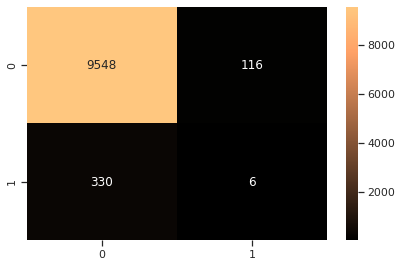

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0178571,0.987997,0.0118851




Additional Info
Total predicted to be positive: 122 

First 23 matches
23 [  6  22  42  44  52 152 163 193 197 201 219 226 253 259 279 283 291 298
 322 352 380 392 498]

[0.50080395 0.50334287 0.5052871  0.5025526  0.50145906 0.50012857
 0.5027822  0.5054151  0.5028476  0.5026786  0.5015116  0.50095034
 0.50019866 0.50203264 0.5010221  0.5063149  0.5008269  0.5005599
 0.5006754  0.50294393 0.5028974  0.5049916  0.5015267 ]


Top 23 Probable Matches

[1597  594 2958   42 5301 1531 4060 2479 5311 4609 2107 1949 3105 1047
  392 1271 1207 1553  283 1702 3576  193 7181]


[0.50449854 0.5045001  0.5048205  0.5052871  0.5084969  0.5076182
 0.505373   0.5093117  0.51060724 0.5060254  0.50597495 0.51323
 0.5053036  0.5102036  0.5049916  0.5059752  0.5057163  0.5076201
 0.5063149  0.5054221  0.5052292  0.5054151  0.5069316 ]


2 To 3 Digits

43 [ 22  42  44  52 152 163 193 197 201 219 226 253 259 279 283 291 298 322
 352 380 392 498 507 540 546 559 567 581 594 604 628 722 731 732 789 838
 851 

In [48]:
weight=1.0
decrement = 0.000
to_stop=False

dt = pd.datetime(2019,6,1)
%time gen_train_test_set(dt, feature_matrix_selection, file_prefix='test')
while not to_stop:
  to_stop = model(dt, feature_matrix_selection, file_prefix='test', class_weight=(weight-decrement))
  decrement = decrement + 0.001


2019-07-01 00:00:00
-------------------

Training on 899893 observations.
Testing on 10000 observations.

Data shape before balancing: (899893, 62)

Counts of strikes vs non-strikes in previous data:
0    869724
1     30169
Name: Label, dtype: int64
----------------------------------------

NO balancing
Data shape after balancing: (899893, 62)

Counts of strikes VS non-strikes in new data:
0    869724
1     30169
Name: Label, dtype: int64

Filtering features

Data shape before feature selection: (899893, 62)

Counts of strikes vs non-strikes before feature selection:
0    869724
1     30169
Name: Label, dtype: int64
----------------------------------------
----------------------------------------

Data shape after feature selection: (899893, 32)

Counts of strikes vs non-strikes in new data:
0    869724
1     30169
Name: Label, dtype: int64

-----------2019-07-01 00:00:00-----------------

Data shape
(899893, 31) (899893,) (10000, 31) (10000,)

Calculating scale pos weight
Counter({0:

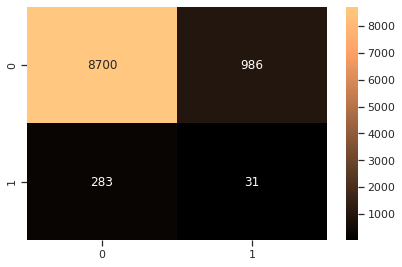

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0987261,0.898204,0.0586216




Additional Info
Total predicted to be positive: 1017 

First 23 matches
23 [ 0  5  9 13 17 18 28 29 33 35 38 42 45 50 52 54 62 64 66 67 72 73 77]

[0.50629705 0.5043603  0.50260824 0.5016583  0.5032644  0.5081183
 0.5073478  0.5027415  0.5072947  0.5144288  0.5043419  0.50598544
 0.5051688  0.5002384  0.5079608  0.5018621  0.50182307 0.50171655
 0.50216424 0.50152576 0.5051814  0.5003338  0.50219536]


Top 23 Probable Matches

[ 594  193  817 5311  823 3591   35 5301  851  895  903 1271  905  581
  661  950 1949 2479  592  298  479 6114  210]


[0.51199836 0.5157651  0.5141168  0.5156203  0.51427156 0.51507765
 0.5144288  0.51325536 0.5125559  0.51364636 0.5189871  0.5166403
 0.5169881  0.5121261  0.5148447  0.51356447 0.5131091  0.5140965
 0.5158624  0.51328874 0.5136101  0.51473165 0.5137958 ]


2 To 3 Digits

291 [ 13  17  18  28  29  33  35  38  42  45  50  52  54  62  64  66  67  72
  73  77  83  90  92 102 104 107 108 111 113 115 116 121 130 131 139 146
 148 151 152 157 163 171

In [0]:
start_mt = pd.datetime(2019,7,1)
how_many_mt = 6 
for i in range(how_many_mt):
  month_to_predict = start_mt + relativedelta(months=i)
  print(f"\n{month_to_predict}\n-------------------\n")

  weight=1.0
  decrement = 0.000
  to_stop=False

  gen_train_test_set(month_to_predict, feature_matrix_selection, file_prefix='test')
  while not to_stop:
    to_stop = model(month_to_predict, feature_matrix_selection, file_prefix='test', class_weight=(weight-decrement))
    decrement = decrement + 0.001
